In [1]:
import autograd.numpy as np
import pandas as pd
import dill
import pyemma
from mdfeature.KramersRateEvaluator import KramersRateEvaluator
from mdfeature.diffusion_utils import compute_discrete_trajectory, correlation_coefficients_check, compute_kramers_rate_from_potential
from mdfeature.plot_utils import plot_free_energy_estimate, plot_free_energy_slice, plot_free_energy_surface
import pydiffmap.diffusion_map as dfm

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Data restore

In [2]:
#dill.dump(double_well_traj, file = open("double_well_traj.pickle", "wb"))
double_well_traj = dill.load(open("double_well_traj.pickle", "rb"))

# Toy Problems in Potential Energy Landscapes

In this notebook we look at
1. Double-Well (1D)
2. Quadruple-Well  (2D)
3. Ring Double Well (2D)
4. Muller-Brown Potential Energy Surface (2D)

In [10]:
def cart2pol(x, y):
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    
    return r, theta

def diffusion_function(x):
    return 1

In [4]:
# Shallow well (1D)
def shallow_well_potential(x):
    return 0.01 * x**2

# Double well (1D)
def double_well_potential(x):
    h = 2
    c = 2
    return -(1/4)*(x**2)*(h**4) + (1/2)*(c**2)*(x**4)

# Quadruple Well (2D)
def quadruple_well_potential(x):
    h = 2
    c = 2
    return (-(1/4)*(x[0]**2)*(h**4) + (1/2)*(c**2)*(x[0]**4))+(-(1/4)*(x[1]**2)*(h**4) + (1/2)*(c**2)*(x[1]**4))

# Ring Double Well (2D)
def ring_double_well_potential(x):
    theta0 = np.pi
    r0 = 1
    w = 0.2
    d = 5
    r, theta = cart2pol(x[0], x[1])
    
    return (1/r) * np.exp(r/r0) - d * np.exp(-((x[0]-r0)**2 + (x[1])**2)/(2*w**2)) - d * np.exp(-((x[0]-r0*np.cos(theta0))**2 + (x[1]-r0*np.sin(theta0))**2)/(2*w**2))

# Muller-Brown Potential (2D)
def muller_brown_potential(x):
    A = (-200, -100, -170, 15)
    a = (-1, -1, -6.5, 0.7)
    b = (0, 0, 11, 0.6)
    c = (-10, -10, -6.5, 0.7)
    x0 = (1, 0, -0.5, -1)
    y0 = (0, 0.5, 1.5, 1)
    
    V = 0
    for k in range(4):
        V += A[k]*np.exp(a[k]*(x[0]-x0[k])**2 + b[k]*(x[0]-x0[k])*(x[1]-y0[k]) + c[k]*(x[1]-y0[k])**2)
        
    return V

## Langevin Dynamics

In [5]:
import matplotlib.pyplot as plt 
from mdfeature.Langevin import LangevinDynamics

temperature = 300
R = 0.0083144621  # Universal Gas Constant kJ/K/mol
beta = 1.0 / (temperature * R)  # units (kJ/mol)**(-1)

step_size = 1e-4

shallow_well_sampler = LangevinDynamics(x0=0.0, potential=shallow_well_potential, beta=beta, time_step=step_size)
double_well_sampler = LangevinDynamics(x0=0.0, potential=double_well_potential, beta=beta, time_step=step_size)
quadruple_well_sampler = LangevinDynamics(x0=[0.0,0.0], potential=quadruple_well_potential, beta=beta, time_step=step_size)
ring_double_well_sampler = LangevinDynamics(x0=[0.2,1.0], potential=ring_double_well_potential, beta=beta, time_step=step_size)
muller_brown_sampler = LangevinDynamics(x0=[0.0,0.0], potential=muller_brown_potential, beta=beta, time_step=step_size)

Kramers Rate Evaluator

In [6]:
kre = KramersRateEvaluator(verbose=True)

Diffusion Maps

In [24]:
dmap = dfm.DiffusionMap.from_sklearn(epsilon = 'bgh', alpha = 0.5, k=64, kernel_type='gaussian', n_evecs=5, neighbor_params=None,
             metric='euclidean', metric_params=None, weight_fxn=None, density_fxn=None, bandwidth_type="-1/(d+2)",
             bandwidth_normalize=False, oos='nystroem')

### Shallow Well 

In [7]:
shallow_well_samples = shallow_well_sampler.simulate(number_of_steps=500000, burn_in=4000, num_processes=1)
shallow_well_traj = np.concatenate(shallow_well_samples).ravel()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500000/500000 [01:10<00:00, 7077.32it/s]


In [6]:
discrete_traj, cluster_centers = compute_discrete_trajectory(shallow_well_traj)
correlation_coefficients_check(beta, shallow_well_potential, discrete_traj, cluster_centers, 500, step_size)

NameError: name 'shallow_well_traj' is not defined

### Double well

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500000/500000 [02:18<00:00, 3607.76it/s]


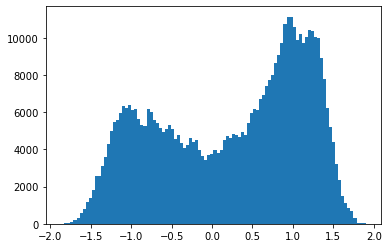

In [7]:
double_well_samples = double_well_sampler.simulate(number_of_steps=500000, burn_in=1000, num_processes=1)
double_well_traj = np.concatenate(double_well_samples).ravel()
plt.hist(double_well_traj, bins=100)
plt.show()

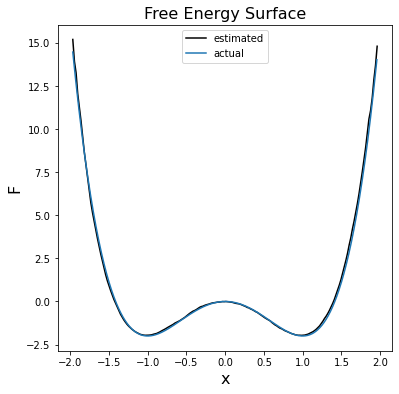

In [15]:
plot_free_energy_estimate(double_well_potential, double_well_traj, beta, minimum_counts=500)

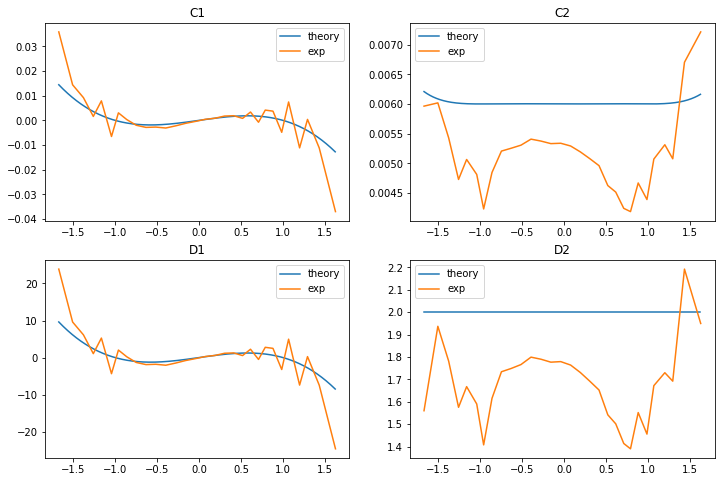

In [25]:
#discrete_traj, cluster_centers = compute_discrete_trajectory(double_well_traj)
correlation_coefficients_check(beta, double_well_potential, discrete_traj, cluster_centers, 15, step_size)

Debug: default clustering None, num default clusters None, k 200


initialize kmeans++ centers:   0%|                                                                            …

kmeans iterations:   0%|                                                                                      …

28-06-22 16:09:08 pyemma.coordinates.clustering.kmeans.KmeansClustering[0] WARNING  Algorithm did not reach convergence criterion of 1e-05 in 150 iterations. Consider increasing max_iter.


/home/dominic/miniconda3/envs/diffusion/lib/python3.9/site-packages/deeptime/clustering/_kmeans.py:466: UserWarning: Algorithm did not reach convergence criterion of 1e-05 in 150 iterations. Consider increasing max_iter.
  warnings.warn(f"Algorithm did not reach convergence criterion"


estimating MaximumLikelihoodMSM:   0%|                                                                        …

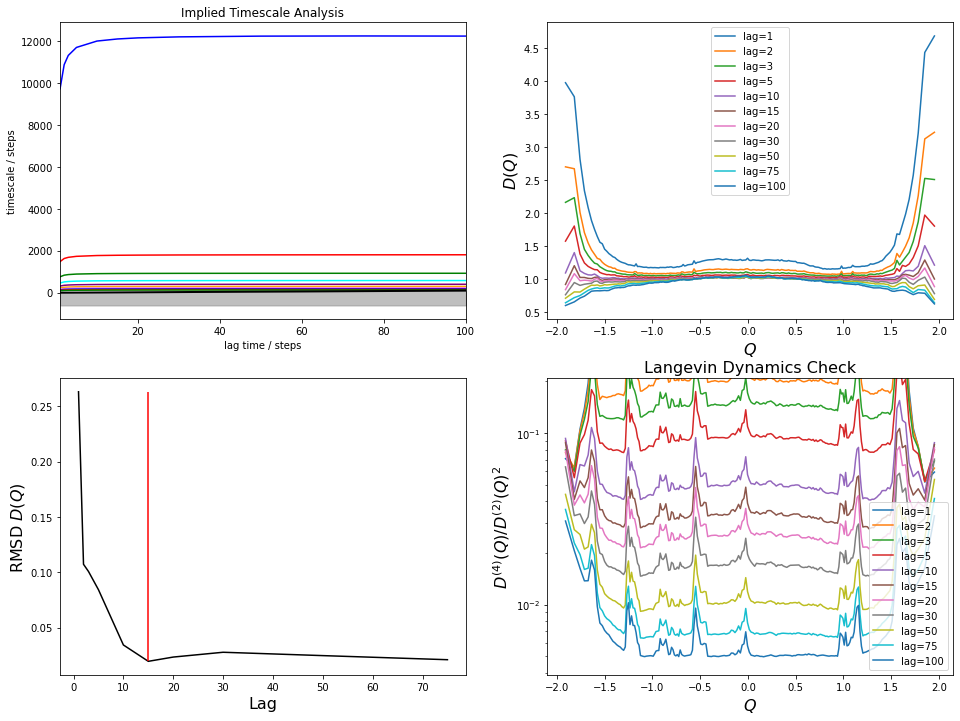

MSM created with 200 states, using lag time 10.


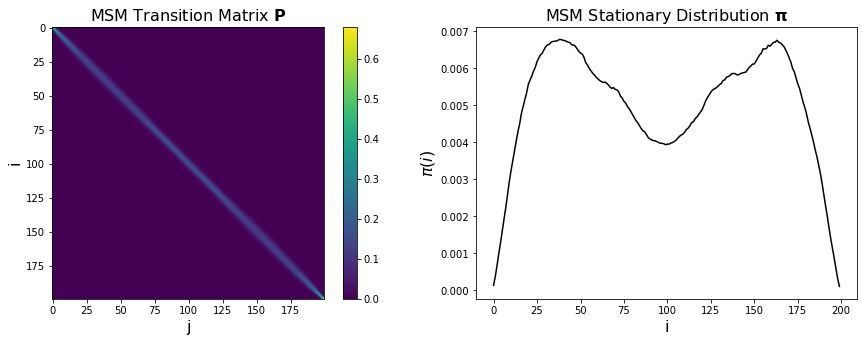

Free energy profile suggests 2 minima.
Minima  (-1.012, 0.009)
Minima  (0.984, 0.006)


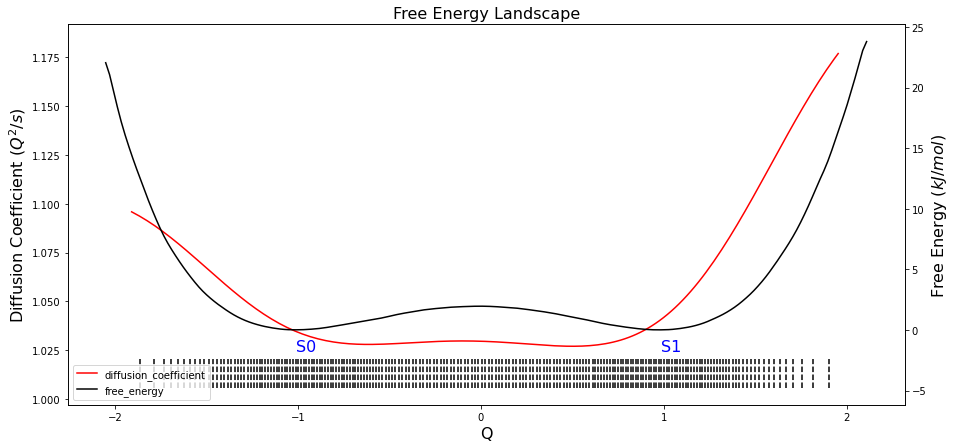

Kramer's Rates
-------------------------
S0 --> S1 : 4.872763e-01
S1 --> S0 : 4.850608e-01
-------------------------


[((0, 1), 0.487276274828937), ((1, 0), 0.4850607573623208)]

In [7]:
kre.fit(double_well_traj, 
        beta, 
        sigmaD=0.5,
        sigmaF=0.025,
        lag=10,
        time_step=step_size,
        k=200)

In [11]:
analytic_kramers_rate = compute_kramers_rate_from_potential(double_well_potential, beta, -1, 1, diffusion_function)
print(analytic_kramers_rate)

0.4627658580543349


In [12]:
kre.msm.compute_transition_rate(state_A = [-1.02, -0.98], state_B = [0.98, 1.02])

0.3010556185099874

### Quadruple Well

In [22]:
quadruple_well_samples = quadruple_well_sampler.simulate(number_of_steps=10000000, burn_in=4000)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 909090/909090 [11:38<00:00, 1301.43it/s]


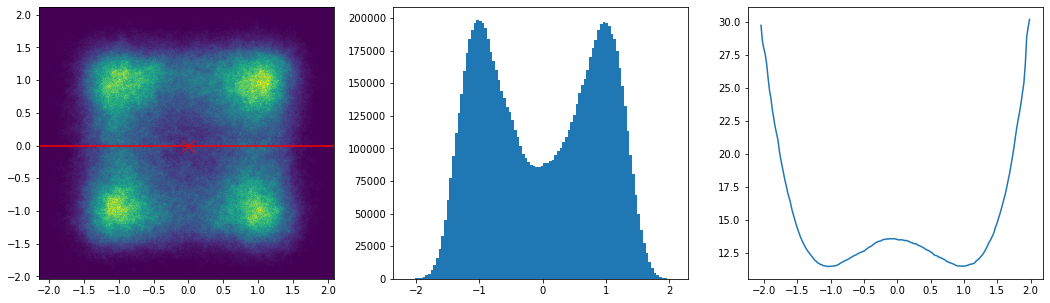

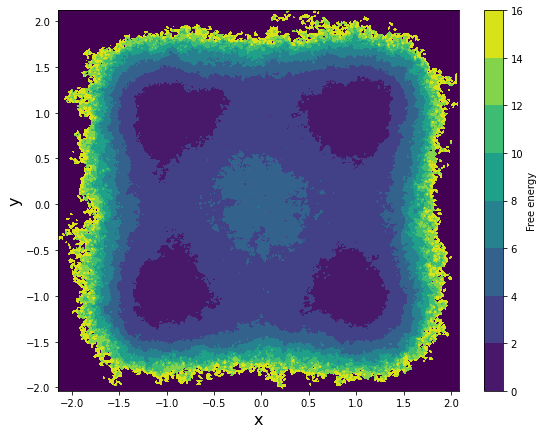

In [23]:
quadruple_well_projected_traj = plot_free_energy_slice(quadruple_well_samples, beta, np.array([0,0]), 0, minimum_counts=50)
plot_free_energy_surface(quadruple_well_samples, beta)

In [ ]:
kre.fit(quadruple_well_projected_traj, 
        beta, 
        sigmaD=0.5,
        sigmaF=0.00025,
        lag = 3,
        bins=200, 
        step_size=step_size,
        minima_prominance=2.0, 
        cluster_type='kmeans',
        options={'k': 200, 'stride': 5, 'max_iter': 150,
         'max_centers': 1000, 'metric': 'euclidean', 'n_jobs': None, 'dmin': 0.002})

### Ring double well

In [26]:
ring_double_well_samples = ring_double_well_sampler.simulate(number_of_steps=10000000, burn_in=4000)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 909090/909090 [18:42<00:00, 809.79it/s]


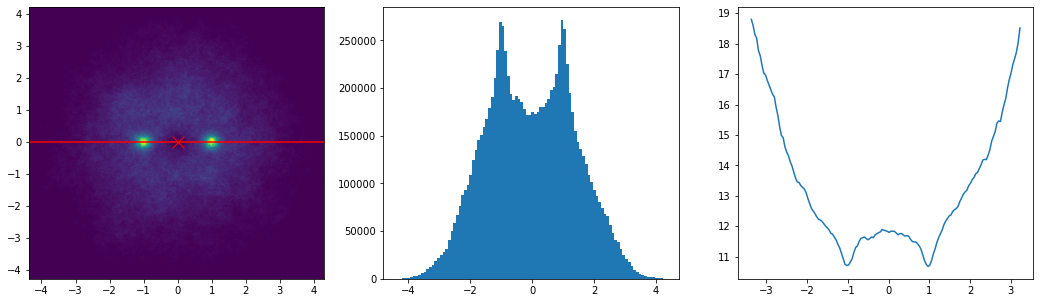

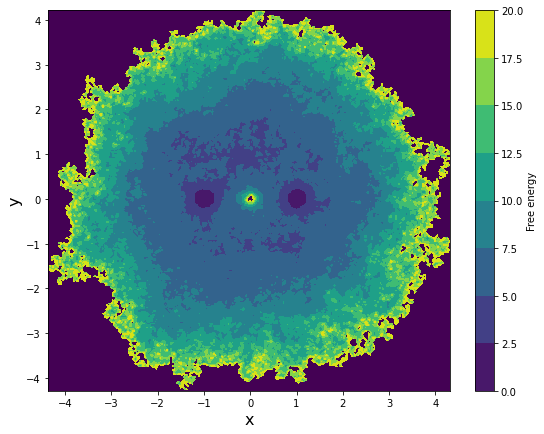

In [27]:
ring_double_well_projected_traj = plot_free_energy_slice(ring_double_well_samples, beta, np.array([0,0]), 0, minimum_counts=5000)
plot_free_energy_surface(ring_double_well_samples, beta)

In [21]:
ring_double_traj = np.concatenate(ring_double_well_samples)
dmap.fit(ring_double_well_traj)

NameError: name 'dmap' is not defined

### Muller brown samples

In [ ]:
muller_brown_samples = muller_brown_sampler.simulate(number_of_steps=10000000, burn_in=4000)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 909090/909090 [39:56<00:00, 379.39it/s]


In [ ]:
muller_brown_projected_traj = plot_free_energy_slice(muller_brown_samples, beta, np.array([0,0]), np.pi/8, minimum_counts=5000)
plot_free_energy_surface(muller_brown_samples, beta)